In [1]:
import pandas as pd
import numpy as np
import ast
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

In [4]:
catalog_df = pd.read_csv('drive/MyDrive/collab_files/product_catalog.csv')
catalog_df

product_id  manufacturer_id  attribute_1  attribute_2  attribute_3  \
0           22665              861            4            0          490   
1           28640             1366           10            1          537   
2           13526             1090           10            0          511   
3           21399             1090           10            1          511   
4            8504              768            4            1          484   
...           ...              ...          ...          ...          ...   
32771       12036             1383           10            0          503   
32772       22709              567            4            2          491   
32773       32322             1385           10            1          500   
32774       19118             1113            6            2          491   
32775       16083             1111            4            3          485   

       attribute_4  attribute_5  \
0                2           66   
1                0          101   
2                0            0   
3                0            0   
4                0           66   
...            ...          ...   
32771            0          101   
32772            3           66   
32773            0           37   
32774            0          117   
32775            3           16   

                                              categories  
0                                [2890, 855, 3908, 3909]  
1                                                    NaN  
2      [3270, 163, 284, 1694, 12, 3837, 2422, 3595, 3...  
3                                                 [3270]  
4                                                 [2470]  
...                                                  ...  
32771  [3502, 1088, 2004, 691, 3422, 2308, 308, 3688,...  
32772     [3900, 3905, 3903, 3910, 1807, 274, 1467, 914]  
32773                                  [2686, 2609, 725]  
32774                 [3900, 3910, 3903, 2473, 914, 274]  
32775   [3900, 3901, 3905, 3902, 3903, 3910, 2473, 2470]  

[32776 rows x 8 columns]

In [5]:
catalog_df['categories'].value_counts().iloc[10:20]

categories
[1980]          123
[3138]          111
[163]           108
[3424]          103
[3278]           80
[1629, 3979]     77
[1350]           75
[146, 1138]      74
[2470]           73
[667]            71
Name: count, dtype: int64

In [6]:
print("# -1 values in attributes")
for i in range(1,6):
  str1 = 'attribute_'+ str(i)
  print(f"{str1} : {catalog_df[catalog_df[str1]==-1]['product_id'].count()}")

# -1 values in attributes
attribute_1 : 4
attribute_2 : 0
attribute_3 : 466
attribute_4 : 617
attribute_5 : 4264


In [7]:
pd.set_option('display.max_rows', None)       # Show all rows
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)


In [8]:
# Step 1: Calculate the mode for each group
mode_values = catalog_df.groupby(['attribute_2', 'attribute_1'])['categories'].agg(lambda x: pd.Series.mode(x))

# Step 2: Map the mode values back to the original DataFrame
catalog_df['mode_fill'] = catalog_df.set_index(['attribute_2', 'attribute_1']).index.map(mode_values)

# Step 3: Fill NaN values in 'categories' with the corresponding mode values
catalog_df['categories'].fillna(catalog_df['mode_fill'], inplace=True)

# Drop the temporary 'mode_fill' column if no longer needed
catalog_df.drop(columns=['mode_fill'], inplace=True)


In [9]:
catalog_df.isna().sum()

product_id         0
manufacturer_id    0
attribute_1        0
attribute_2        0
attribute_3        0
attribute_4        0
attribute_5        0
categories         0
dtype: int64

In [10]:
catalog_df.loc[14463,'categories'] = [308] # for the empty list

In [11]:
catalog_df['categories'] = catalog_df['categories'].astype(str)

In [12]:
# target_categories = [3916,2136,3900,300,1984,3810,2209,1708,1221,981,2834,2995,3901,3283,3639,1807,1098,1628,1772,3908,1298,2165,300,1529,3915,3222,308,2732,3625,3254,1085,2833,1138,146,327,74]

In [13]:
# catalog_df['categories'] = catalog_df['categories'].apply(ast.literal_eval)

In [14]:
# def assign_category(cat_list):
#     if len(cat_list) == 1 and isinstance(cat_list[0],int):
#         return int(cat_list[0])
#     for target in target_categories:
#         if target in cat_list:
#             return int(target)
#     return cat_list
# catalog_new = catalog_df.copy()
# catalog_new['categories'] = catalog_df['categories'].apply(assign_category)
# catalog_new.head(10)

In [15]:
# type(catalog_new.loc[32655,'categories'])

In [16]:
# # Filter rows where 'categories' column entries are not integers
# non_integer_rows = catalog_new[catalog_new['categories'].apply(lambda x: not isinstance(x, int))].reset_index(drop=True)
# len(non_integer_rows)

In [17]:
# from collections import Counter


# # String formatındaki listeleri dönüştürme
# # Tüm kategorileri bir araya getirme
# all_categories = [item for sublist in non_integer_rows['categories'] for item in sublist]

# # En çok tekrar eden kategorileri bulma
# category_counts = Counter(all_categories)
# most_common_categories = category_counts.most_common(20)

# # Sonucu yazdırma
# print(most_common_categories)


In [18]:
category_map_df = pd.read_csv("/content/drive/MyDrive/collab_files/product_category_map.csv")
category_map_df.head()

category_id  parent_category_id
0            0                  75
1            1                1499
2            2                1082
3            3                3498
4            4                1623

In [19]:
category_map_df = category_map_df.drop_duplicates(subset=['category_id'])
category_map_df[category_map_df['category_id'].duplicated(keep=False)]

Empty DataFrame
Columns: [category_id, parent_category_id]
Index: []

In [20]:
category_map_df[category_map_df['category_id']==category_map_df['parent_category_id']]['category_id'].values

array([3898])

In [21]:
def category_mapper(df):
  top_nodes = df[df['category_id']==df['parent_category_id']]['category_id'].values
  category_map_df_filtered = df.copy()
  category_map_df_filtered.loc[category_map_df_filtered['parent_category_id'].isin(top_nodes),'parent_category_id']=category_map_df_filtered['category_id']
  parent_list=category_map_df_filtered[category_map_df_filtered['category_id']==category_map_df_filtered['parent_category_id']]['category_id'].values
  return category_map_df_filtered,parent_list


In [22]:
catalog_df['categories'] = catalog_df['categories'].apply(ast.literal_eval)
catalog_df['categories'] = catalog_df['categories'].apply(lambda x: sorted(x))

catalog_df.loc[0,'categories']

[855, 2890, 3908, 3909]

In [23]:
def category_row_transform(row, df_map, parents):
    category = row['categories']
    # Check if the first element is an integer; if not, set it to 3898
    if not isinstance(category[0], int):
        element = int(category[0][1:5])
    else:
      element = int(category[0])
    while element not in parents:
        element = df_map.loc[df_map['category_id'] == element, 'parent_category_id'].values[0]
    row['categories'] = element
    return row


In [24]:
category_map_df_filtered, parent_list = category_mapper(category_map_df)
parent_list

array([  34,  182,  252,  275,  298,  322,  336,  366,  370,  381,  422,
        432,  519,  535,  600,  621,  678,  686,  754,  857,  875,  959,
        965, 1062, 1072, 1102, 1447, 1480, 1528, 1543, 1557, 1559, 1565,
       1666, 1677, 1682, 1735, 1763, 1790, 1825, 1840, 2006, 2011, 2012,
       2105, 2109, 2209, 2231, 2346, 2364, 2371, 2597, 2723, 2762, 2793,
       2838, 2855, 2917, 2920, 2928, 3056, 3077, 3110, 3189, 3263, 3283,
       3288, 3330, 3409, 3444, 3451, 3476, 3504, 3540, 3613, 3616, 3617,
       3624, 3685, 3752, 3852, 3860, 3898, 3899, 3900, 3901, 3902, 3903,
       3904, 3905, 3906, 3907, 3908, 3909, 3910, 3911, 3912, 3913, 3914,
       3915, 3916, 3917, 3918, 3919, 3920, 3921, 3922, 3923, 3924, 3925,
       3926, 3927, 3928, 3929, 3930, 3931, 3932, 3933, 3934, 3935, 3936,
       3937, 3938, 3939, 3940, 3941, 3942, 3943, 3944, 3945, 3946, 3947,
       3948, 3949, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 3958,
       3959, 3960, 3961, 3962, 3963, 3964, 3965, 39

In [25]:
# Set 'parent_category_id' and 'category_id' to 3898 if they are greater than 3898
category_map_df_filtered.loc[category_map_df_filtered['parent_category_id'] >= 3898, 'parent_category_id'] = 3898
category_map_df_filtered.loc[category_map_df_filtered['category_id'].astype(int) >= 3898, 'category_id'] = 3898
category_map_df_filtered = category_map_df_filtered.drop_duplicates(subset=['category_id', 'parent_category_id'])


In [26]:
catalog_df_transformed = catalog_df.apply(lambda row: category_row_transform(row,category_map_df_filtered,parent_list),axis=1)

In [27]:
vcounts= catalog_df_transformed['categories'].value_counts()
len(vcounts)

106

<Axes: xlabel='categories'>

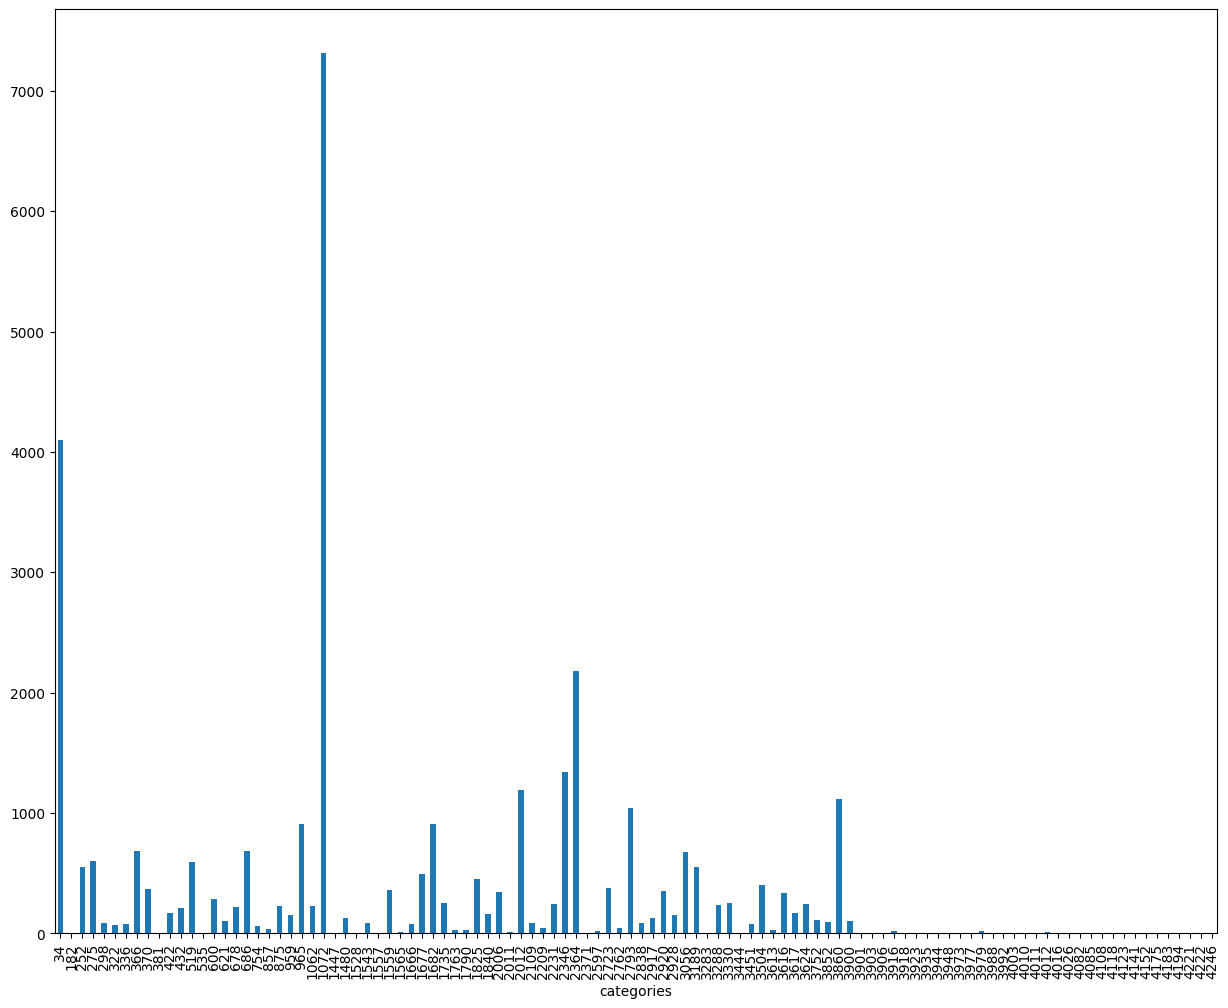

In [28]:
value_counts_filtered = vcounts.sort_index()
value_counts_filtered.plot(kind='bar', figsize=(15, 12))


In [29]:
catalog_df_transformed.loc[catalog_df_transformed['categories'] == 182, 'categories'] = 34
catalog_df_transformed.loc[catalog_df_transformed['categories'] == 336, 'categories'] = 366
catalog_df_transformed.loc[catalog_df_transformed['categories'] == 252, 'categories'] = 275
catalog_df_transformed.loc[catalog_df_transformed['categories'] >= 3898, 'categories'] = 3898
catalog_df_transformed.loc[catalog_df_transformed['categories'] == 422, 'categories'] = 432
catalog_df_transformed.loc[catalog_df_transformed['categories'] == 678, 'categories'] = 686
catalog_df_transformed.loc[catalog_df_transformed['categories'] == 857, 'categories'] = 875
catalog_df_transformed.loc[catalog_df_transformed['categories'] == 1062, 'categories'] = 1072
catalog_df_transformed.loc[catalog_df_transformed['categories'] == 422, 'categories'] = 432
catalog_df_transformed.loc[catalog_df_transformed['categories'] == 1557, 'categories'] = 1559
catalog_df_transformed.loc[catalog_df_transformed['categories'] == 1565, 'categories'] = 1559
catalog_df_transformed.loc[catalog_df_transformed['categories'] == 1666, 'categories'] = 1677
catalog_df_transformed.loc[catalog_df_transformed['categories'] == 2011, 'categories'] = 2012
catalog_df_transformed.loc[catalog_df_transformed['categories'] == 2209, 'categories'] = 2109
catalog_df_transformed.loc[catalog_df_transformed['categories'] == 2346, 'categories'] = 2364
catalog_df_transformed.loc[catalog_df_transformed['categories'] == 422, 'categories'] = 432
catalog_df_transformed.loc[catalog_df_transformed['categories'] == 3283, 'categories'] = 3288
catalog_df_transformed.loc[catalog_df_transformed['categories'] == 3540, 'categories'] = 3504
catalog_df_transformed.loc[catalog_df_transformed['categories'] == 3613, 'categories'] = 3617
catalog_df_transformed.loc[catalog_df_transformed['categories'] == 3616, 'categories'] = 3617
catalog_df_transformed.loc[catalog_df_transformed['categories'] == 3752, 'categories'] = 3852









<Axes: xlabel='categories'>

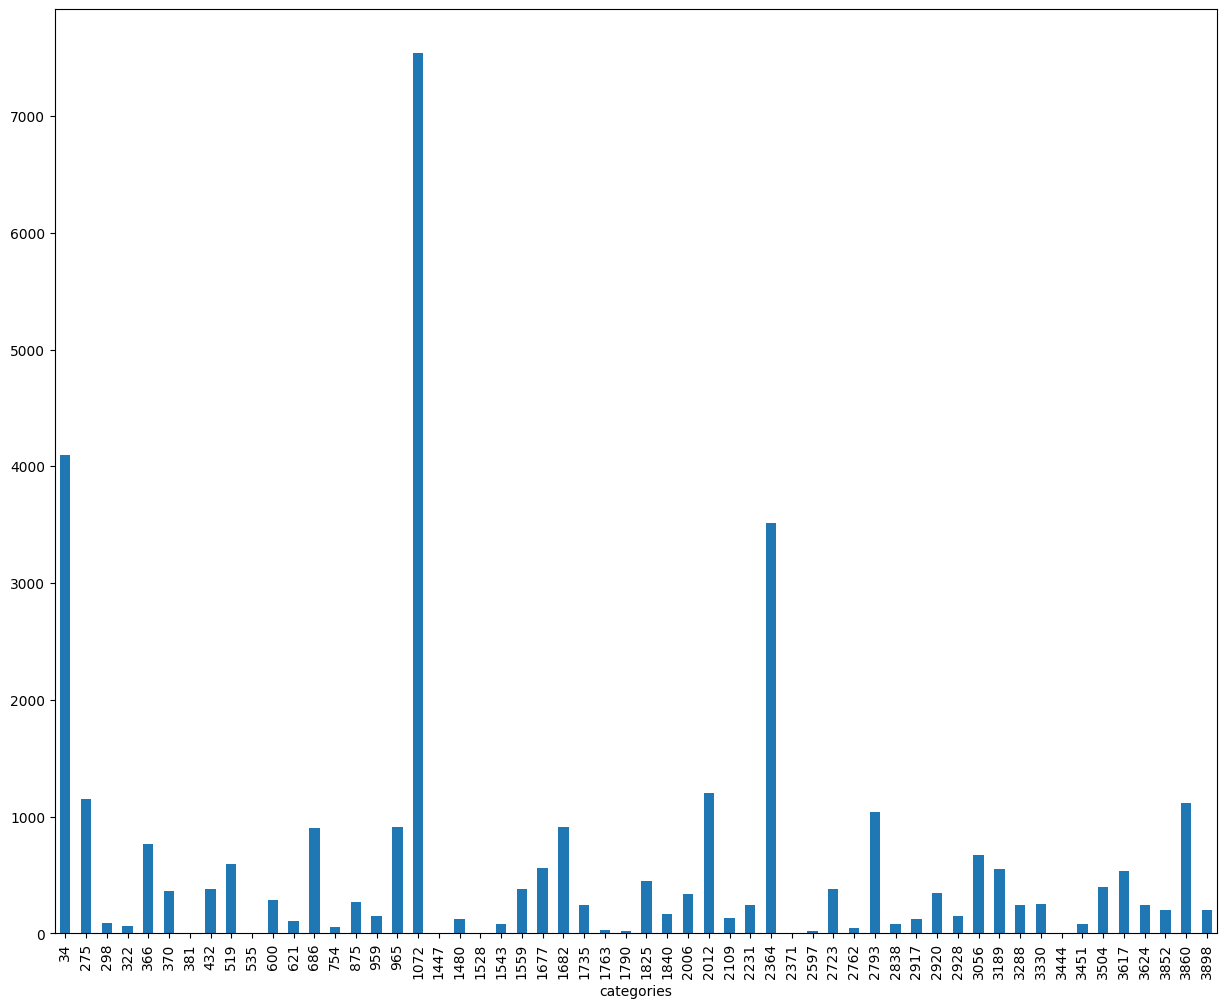

In [30]:
vcounts= catalog_df_transformed['categories'].value_counts()
value_counts_filtered = vcounts.sort_index()
value_counts_filtered.plot(kind='bar', figsize=(15, 12))

In [31]:
transactions_df= pd.read_csv("drive/MyDrive/collab_files/transactions.csv")
transactions_df.head()
transactions_df[transactions_df['customer_id']==38769].sort_values(by=['product_id','purchase_date']).head(40)


customer_id  product_id purchase_date  quantity
196634        38769         631    2020-07-16         3
795429        38769         637    2020-12-06         1
7935          38769         652    2020-06-02         1
700506        38769         697    2020-11-17         1
795426        38769        2130    2020-12-06         1
126602        38769        2730    2020-06-30         1
599956        38769        2730    2020-10-22         1
0             38769        3477    2020-06-01         1
795424        38769        3535    2020-12-06         1
126578        38769        4130    2020-06-30         2
330780        38769        4402    2020-08-17         1
726231        38769        4685    2020-11-23         1
762780        38769        5197    2020-11-30         1
535341        38769        6876    2020-10-07         1
2532          38769        7449    2020-06-01         1
926687        38769        7970    2021-01-05         1
726230        38769        7997    2020-11-23         1
762781        38769        8032    2020-11-30         1
762776        38769        8367    2020-11-30         1
146677        38769        8524    2020-07-05         1
762777        38769        8941    2020-11-30         1
126603        38769        9375    2020-06-30         6
7936          38769        9880    2020-06-02         1
330603        38769        9880    2020-08-17         1
645607        38769       10302    2020-11-03         1
2546          38769       10507    2020-06-01         1
329143        38769       10507    2020-08-17         2
599954        38769       10507    2020-10-22         4
715281        38769       10507    2020-11-21         2
926710        38769       10507    2021-01-05         2
2556          38769       11213    2020-06-01         1
443189        38769       11251    2020-09-15         1
196635        38769       11835    2020-07-16         1
926697        38769       12032    2021-01-05         1
535340        38769       12439    2020-10-07         1
7931          38769       12745    2020-06-02         1
926712        38769       13019    2021-01-05         1
196636        38769       13624    2020-07-16         1
726229        38769       14408    2020-11-23         1
535339        38769       15053    2020-10-07         1

In [32]:
train_start = transactions_df.merge(catalog_df_transformed, on='product_id', how='left')
train_start= train_start.drop(columns=['manufacturer_id','quantity'])
train_start.head()

customer_id  product_id purchase_date  attribute_1  attribute_2  \
0        38769        3477    2020-06-01            6            0   
1        42535       30474    2020-06-01           10            3   
2        42535       15833    2020-06-01            4            1   
3        42535       20131    2020-06-01            4            0   
4        42535        4325    2020-06-01            6            0   

   attribute_3  attribute_4  attribute_5  categories  
0          196            0           45        3056  
1          229            3          132        1677  
2          455            0          108         275  
3          291            3           44        1682  
4          303            0           45        3624

In [33]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
import pandas as pd

# Assuming 'train_start' contains 'customer_id' and 'categories' columns
# Step 1: One-hot encode the 'categories' column for each customer
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(train_start[['attribute_1','attribute_2','attribute_3']])

# Create a DataFrame with one-hot encoded categories
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out())

# Concatenate 'customer_id' with the encoded features
encoded_df = pd.concat([train_start[['customer_id']].reset_index(drop=True), encoded_df], axis=1)
encoded_df.head()

customer_id  attribute_1_-1  attribute_1_0  attribute_1_1  attribute_1_2  \
0        38769             0.0            0.0            0.0            0.0   
1        42535             0.0            0.0            0.0            0.0   
2        42535             0.0            0.0            0.0            0.0   
3        42535             0.0            0.0            0.0            0.0   
4        42535             0.0            0.0            0.0            0.0   

   attribute_1_3  attribute_1_4  attribute_1_5  attribute_1_6  attribute_1_7  \
0            0.0            0.0            0.0            1.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            1.0            0.0            0.0            0.0   
3            0.0            1.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            1.0            0.0   

   ...  attribute_3_529  attribute_3_530  attribute_3_531  attribute_3_532  \
0  ...              0.0              0.0              0.0              0.0   
1  ...              0.0              0.0              0.0              0.0   
2  ...              0.0              0.0              0.0              0.0   
3  ...              0.0              0.0              0.0              0.0   
4  ...              0.0              0.0              0.0              0.0   

   attribute_3_533  attribute_3_534  attribute_3_535  attribute_3_536  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              0.0              0.0   
2              0.0              0.0              0.0              0.0   
3              0.0              0.0              0.0              0.0   
4              0.0              0.0              0.0              0.0   

   attribute_3_537  attribute_3_538  
0              0.0              0.0  
1              0.0              0.0  
2              0.0              0.0  
3              0.0              0.0  
4              0.0              0.0  

[5 rows x 557 columns]

In [34]:
customer_encoded = encoded_df.groupby('customer_id').sum()

# Step 3: Apply KMeans clustering on the aggregated customer features
k_clusters = 40 # Define the number of clusters
kmeans = KMeans(n_clusters=k_clusters, random_state=42)
customer_clusters = kmeans.fit_predict(customer_encoded)

# Step 4: Add cluster labels to the customer DataFrame
customer_encoded['cluster'] = customer_clusters

# Optional: Display the first few rows with 'customer_id' and their assigned cluster
customer_encoded.groupby(['cluster']).count()

attribute_1_-1  attribute_1_0  attribute_1_1  attribute_1_2  \
cluster                                                                
0                  2110           2110           2110           2110   
1                   520            520            520            520   
2                  2050           2050           2050           2050   
3                   271            271            271            271   
4                  1595           1595           1595           1595   
5                    72             72             72             72   
6                  3688           3688           3688           3688   
7                  1225           1225           1225           1225   
8                   211            211            211            211   
9                  3580           3580           3580           3580   
10                 2524           2524           2524           2524   
11                  899            899            899            899   
12                   42             42             42             42   
13                 2850           2850           2850           2850   
14                  269            269            269            269   
15                  274            274            274            274   
16                  695            695            695            695   
17                 1484           1484           1484           1484   
18                   21             21             21             21   
19                 1172           1172           1172           1172   
20                 4018           4018           4018           4018   
21                 1549           1549           1549           1549   
22                 1798           1798           1798           1798   
23                    8              8              8              8   
24                  606            606            606            606   
25                  357            357            357            357   
26                 1619           1619           1619           1619   
27                  121            121            121            121   
28                  858            858            858            858   
29                   53             53             53             53   
30                  788            788            788            788   
31                 3519           3519           3519           3519   
32                  107            107            107            107   
33                    1              1              1              1   
34                  222            222            222            222   
35                  697            697            697            697   
36                  518            518            518            518   
37                  216            216            216            216   
38                 2544           2544           2544           2544   
39                  987            987            987            987   

         attribute_1_3  attribute_1_4  attribute_1_5  attribute_1_6  \
cluster                                                               
0                 2110           2110           2110           2110   
1                  520            520            520            520   
2                 2050           2050           2050           2050   
3                  271            271            271            271   
4                 1595           1595           1595           1595   
5                   72             72             72             72   
6                 3688           3688           3688           3688   
7                 1225           1225           1225           1225   
8                  211            211            211            211   
9                 3580           3580           3580           3580   
10                2524           2524           2524           2524   
11                 899            899            899         

In [35]:
customer_encoded= customer_encoded['cluster']
customer_encoded.head()

customer_id
0    10
1     6
2     4
3     1
4    13
Name: cluster, dtype: int32

In [36]:
customer_encoded = customer_encoded.reset_index()
customer_encoded.head()


customer_id  cluster
0            0       10
1            1        6
2            2        4
3            3        1
4            4       13

In [37]:
train_cluster = train_start.merge(customer_encoded[['customer_id', 'cluster']], on='customer_id', how='left')
train_cluster=train_cluster.sort_values(by=['cluster','product_id']).reset_index(drop=True)
train_cluster.head(30)

customer_id  product_id purchase_date  attribute_1  attribute_2  \
0         28009           6    2020-07-04           10            0   
1          7371           6    2020-07-07           10            0   
2          5423           6    2020-07-24           10            0   
3         36079           6    2020-08-30           10            0   
4         35331           6    2020-09-12           10            0   
5         28009           6    2020-10-13           10            0   
6         35331           6    2021-01-02           10            0   
7         19657           9    2020-07-04            4            1   
8           213           9    2020-08-30            4            1   
9         19657           9    2020-09-19            4            1   
10        31388           9    2020-11-17            4            1   
11        29876          11    2020-08-21           10            1   
12        29876          11    2020-12-01           10            1   
13        29442          17    2020-12-16            4            1   
14        35509          21    2020-10-08           10            0   
15        31707          25    2020-09-23           10            0   
16         4461          28    2020-06-14            4            1   
17        17113          30    2021-01-05            4            0   
18        31732          34    2020-06-03            4            0   
19        40970          34    2020-06-23            4            0   
20        43315          34    2020-06-23            4            0   
21        35848          34    2020-06-27            4            0   
22        20512          34    2020-07-17            4            0   
23        39199          34    2020-07-31            4            0   
24        40970          34    2020-09-09            4            0   
25        45726          34    2020-09-27            4            0   
26        27806          34    2020-09-27            4            0   
27        14747          34    2020-11-07            4            0   
28         7641          34    2020-11-13            4            0   
29        43315          34    2020-11-30            4            0   

    attribute_3  attribute_4  attribute_5  categories  cluster  
0            51            0          127        2012        0  
1            51            0          127        2012        0  
2            51            0          127        2012        0  
3            51            0          127        2012        0  
4            51            0          127        2012        0  
5            51            0          127        2012        0  
6            51            0          127        2012        0  
7           291            3          175        1682        0  
8           291            3          175        1682        0  
9           291            3          175        1682        0  
10          291            3          175        1682        0  
11           18            0          141        2012        0  
12           18            0          141        2012        0  
13          491            0          144        1072        0  
14          503            3           17         965        0  
15          503            3           85        3189        0  
16          469            0           -1        2723        0  
17          536            3          144         370        0  
18          536            3          144         370        0  
19          536            3          144         370        0  
20          536            3          144         370        0  
21          536            3          144         370        0  
22          536            3          144         370        0  
23          536            3          144         370        0  
24          536            3          144         370        0  
25          536            3          144         370        0  
26          536            3          144      

In [38]:
train_cluster['purchase_date'] = pd.to_datetime(train_cluster['purchase_date'])
train_cluster = train_cluster.sort_values(by=['cluster', 'product_id', 'purchase_date']).reset_index(drop=True)
train_cluster.tail(15)

customer_id  product_id purchase_date  attribute_1  attribute_2  \
1071523        12417       32752    2020-07-12            4            1   
1071524         1472       32752    2020-09-17            4            1   
1071525        34099       32752    2020-10-01            4            1   
1071526        26145       32752    2020-10-18            4            1   
1071527        24026       32752    2020-12-14            4            1   
1071528        12417       32752    2020-12-14            4            1   
1071529        30306       32752    2020-12-20            4            1   
1071530        24083       32752    2020-12-30            4            1   
1071531         9224       32752    2021-01-02            4            1   
1071532        24083       32752    2021-01-26            4            1   
1071533         1417       32752    2021-01-31            4            1   
1071534        42816       32768    2020-10-08           10            0   
1071535        40489       32769    2020-06-13            6            0   
1071536        15038       32769    2021-01-16            6            0   
1071537         5716       32772    2020-09-07            6            1   

         attribute_3  attribute_4  attribute_5  categories  cluster  
1071523          290            0           44        3624       39  
1071524          290            0           44        3624       39  
1071525          290            0           44        3624       39  
1071526          290            0           44        3624       39  
1071527          290            0           44        3624       39  
1071528          290            0           44        3624       39  
1071529          290            0           44        3624       39  
1071530          290            0           44        3624       39  
1071531          290            0           44        3624       39  
1071532          290            0           44        3624       39  
1071533          290            0           44        3624       39  
1071534          416            3            3        2723       39  
1071535          502            0          124        2364       39  
1071536          502            0          124        2364       39  
1071537          503            0           17        1559       39

In [39]:
train_cluster['days_diff'] = train_cluster.groupby(['cluster', 'product_id'])['purchase_date'].diff().dt.days
train_cluster.head(15)

customer_id  product_id purchase_date  attribute_1  attribute_2  \
0         28009           6    2020-07-04           10            0   
1          7371           6    2020-07-07           10            0   
2          5423           6    2020-07-24           10            0   
3         36079           6    2020-08-30           10            0   
4         35331           6    2020-09-12           10            0   
5         28009           6    2020-10-13           10            0   
6         35331           6    2021-01-02           10            0   
7         19657           9    2020-07-04            4            1   
8           213           9    2020-08-30            4            1   
9         19657           9    2020-09-19            4            1   
10        31388           9    2020-11-17            4            1   
11        29876          11    2020-08-21           10            1   
12        29876          11    2020-12-01           10            1   
13        29442          17    2020-12-16            4            1   
14        35509          21    2020-10-08           10            0   

    attribute_3  attribute_4  attribute_5  categories  cluster  days_diff  
0            51            0          127        2012        0        NaN  
1            51            0          127        2012        0        3.0  
2            51            0          127        2012        0       17.0  
3            51            0          127        2012        0       37.0  
4            51            0          127        2012        0       13.0  
5            51            0          127        2012        0       31.0  
6            51            0          127        2012        0       81.0  
7           291            3          175        1682        0        NaN  
8           291            3          175        1682        0       57.0  
9           291            3          175        1682        0       20.0  
10          291            3          175        1682        0       59.0  
11           18            0          141        2012        0        NaN  
12           18            0          141        2012        0      102.0  
13          491            0          144        1072        0        NaN  
14          503            3           17         965        0        NaN

In [40]:

train = train_cluster.dropna(subset=['days_diff']).reset_index(drop=True)
train.tail(15)

customer_id  product_id purchase_date  attribute_1  attribute_2  \
795955        20227       32737    2020-08-30           10            0   
795956        31831       32737    2020-12-07           10            0   
795957        16724       32737    2021-01-31           10            0   
795958        12417       32752    2020-07-12            4            1   
795959         1472       32752    2020-09-17            4            1   
795960        34099       32752    2020-10-01            4            1   
795961        26145       32752    2020-10-18            4            1   
795962        24026       32752    2020-12-14            4            1   
795963        12417       32752    2020-12-14            4            1   
795964        30306       32752    2020-12-20            4            1   
795965        24083       32752    2020-12-30            4            1   
795966         9224       32752    2021-01-02            4            1   
795967        24083       32752    2021-01-26            4            1   
795968         1417       32752    2021-01-31            4            1   
795969        15038       32769    2021-01-16            6            0   

        attribute_3  attribute_4  attribute_5  categories  cluster  days_diff  
795955          502            0          178         275       39       49.0  
795956          502            0          178         275       39       99.0  
795957          502            0          178         275       39       55.0  
795958          290            0           44        3624       39       24.0  
795959          290            0           44        3624       39       67.0  
795960          290            0           44        3624       39       14.0  
795961          290            0           44        3624       39       17.0  
795962          290            0           44        3624       39       57.0  
795963          290            0           44        3624       39        0.0  
795964          290            0           44        3624       39        6.0  
795965          290            0           44        3624       39       10.0  
795966          290            0           44        3624       39        3.0  
795967          290            0           44        3624       39       24.0  
795968          290            0           44        3624       39        5.0  
795969          502            0          124        2364       39      217.0

In [41]:
def assign_week_value(days):
    if pd.isna(days) or days > 50:
        return 0
    elif days <= 2:
        return 1
    elif days <= 9:
        return 2
    elif days <= 21:
        return 3
    elif days <= 50:
        return 4

In [42]:
train['week_value'] = train['days_diff'].apply(assign_week_value)
train.sort_values(by=['cluster', 'product_id', 'purchase_date'], inplace=True)
train.head(15)

customer_id  product_id purchase_date  attribute_1  attribute_2  \
0          7371           6    2020-07-07           10            0   
1          5423           6    2020-07-24           10            0   
2         36079           6    2020-08-30           10            0   
3         35331           6    2020-09-12           10            0   
4         28009           6    2020-10-13           10            0   
5         35331           6    2021-01-02           10            0   
6           213           9    2020-08-30            4            1   
7         19657           9    2020-09-19            4            1   
8         31388           9    2020-11-17            4            1   
9         29876          11    2020-12-01           10            1   
10        40970          34    2020-06-23            4            0   
11        43315          34    2020-06-23            4            0   
12        35848          34    2020-06-27            4            0   
13        20512          34    2020-07-17            4            0   
14        39199          34    2020-07-31            4            0   

    attribute_3  attribute_4  attribute_5  categories  cluster  days_diff  \
0            51            0          127        2012        0        3.0   
1            51            0          127        2012        0       17.0   
2            51            0          127        2012        0       37.0   
3            51            0          127        2012        0       13.0   
4            51            0          127        2012        0       31.0   
5            51            0          127        2012        0       81.0   
6           291            3          175        1682        0       57.0   
7           291            3          175        1682        0       20.0   
8           291            3          175        1682        0       59.0   
9            18            0          141        2012        0      102.0   
10          536            3          144         370        0       20.0   
11          536            3          144         370        0        0.0   
12          536            3          144         370        0        4.0   
13          536            3          144         370        0       20.0   
14          536            3          144         370        0       14.0   

    week_value  
0            2  
1            3  
2            4  
3            3  
4            4  
5            0  
6            0  
7            3  
8            0  
9            0  
10           3  
11           1  
12           2  
13           3  
14           3

In [43]:
train['week_value'].value_counts()

week_value
2    199785
1    184631
3    148824
4    144735
0    117995
Name: count, dtype: int64

In [44]:
train.drop(columns=['purchase_date','days_diff','customer_id'],inplace=True)

In [45]:
train.tail()

product_id  attribute_1  attribute_2  attribute_3  attribute_4  \
795965       32752            4            1          290            0   
795966       32752            4            1          290            0   
795967       32752            4            1          290            0   
795968       32752            4            1          290            0   
795969       32769            6            0          502            0   

        attribute_5  categories  cluster  week_value  
795965           44        3624       39           3  
795966           44        3624       39           2  
795967           44        3624       39           4  
795968           44        3624       39           2  
795969          124        2364       39           0

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Assuming train_df is already loaded and normalized/standardized
train_0=train[train['cluster']==0]
# Prepare features (X) and target (y) excluding 'week', 'product_id', 'customer_id', and 'manufacturer_id'
X_0 = train_0.drop(columns=['week_value','product_id','cluster'])
y_0 = train_0['week_value']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_0, y_0, test_size=0.2, random_state=42, stratify=y_0)
X_train.head(15)

attribute_1  attribute_2  attribute_3  attribute_4  attribute_5  \
28989           10            0          395            0            8   
32430           10            0           27            3           38   
3628             6            0          513            0           45   
11096           10            0          376            0           39   
28095           10            0          412            0            3   
13328            4            0           71            0           53   
7099            10            0          391            0           87   
11520           10            0          500            3          185   
1316             4            0          470            0           82   
15612            4            0          291            0           44   
30329            6            0          358            3           98   
20128            6            0          166            0          122   
24204           10            0          503            0           85   
37291            6            0          170            0           45   
366              4            0          399            3          163   

       categories  
28989        2793  
32430        2012  
3628         3860  
11096        2364  
28095        2364  
13328        2012  
7099         2793  
11520        2364  
1316          959  
15612        1682  
30329        2793  
20128        1840  
24204        3189  
37291         686  
366          2231

In [47]:
model_list = []
for k in range(k_clusters):
  cluster_data =train[train['cluster']==k]
  print(k)
  X = cluster_data.drop(columns=['week_value','product_id','cluster'])
  y = cluster_data ['week_value']
  print(X.shape)
  print(y.shape)
  model = RandomForestClassifier(random_state=42)
  model.fit(X, y)
  model_list.append(model)

0
(41011, 6)
(41011,)
1
(15093, 6)
(15093,)
2
(24192, 6)
(24192,)
3
(12622, 6)
(12622,)
4
(28470, 6)
(28470,)
5
(2447, 6)
(2447,)
6
(40714, 6)
(40714,)
7
(39374, 6)
(39374,)
8
(10641, 6)
(10641,)
9
(24466, 6)
(24466,)
10
(38637, 6)
(38637,)
11
(22913, 6)
(22913,)
12
(2114, 6)
(2114,)
13
(43101, 6)
(43101,)
14
(10287, 6)
(10287,)
15
(10542, 6)
(10542,)
16
(13056, 6)
(13056,)
17
(37520, 6)
(37520,)
18
(1303, 6)
(1303,)
19
(33441, 6)
(33441,)
20
(12827, 6)
(12827,)
21
(31747, 6)
(31747,)
22
(30424, 6)
(30424,)
23
(798, 6)
(798,)
24
(19165, 6)
(19165,)
25
(15081, 6)
(15081,)
26
(35373, 6)
(35373,)
27
(6158, 6)
(6158,)
28
(19061, 6)
(19061,)
29
(3010, 6)
(3010,)
30
(28876, 6)
(28876,)
31
(26277, 6)
(26277,)
32
(5404, 6)
(5404,)
33
(195, 6)
(195,)
34
(4675, 6)
(4675,)
35
(27192, 6)
(27192,)
36
(16546, 6)
(16546,)
37
(8371, 6)
(8371,)
38
(28461, 6)
(28461,)
39
(24385, 6)
(24385,)


In [48]:
y_train.head()

28989    4
32430    1
3628     4
11096    2
28095    1
Name: week_value, dtype: int64

In [49]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [50]:
# Make predictions on the validation set
y_pred = model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val.to_numpy(), y_pred)
report = classification_report(y_val.to_numpy(), y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

Accuracy: 0.39
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.30      0.34       908
           1       0.55      0.59      0.57      2378
           2       0.34      0.41      0.37      2234
           3       0.24      0.17      0.20      1450
           4       0.27      0.26      0.26      1233

    accuracy                           0.39      8203
   macro avg       0.36      0.35      0.35      8203
weighted avg       0.38      0.39      0.38      8203



In [51]:
test_df= pd.read_csv("drive/MyDrive/collab_files/test.csv")
test_df.head()

id  customer_id  product_id  prediction
0   0            0       20664         NaN
1   1            0       28231         NaN
2   2           13        2690         NaN
3   3           15        1299         NaN
4   4           15       20968         NaN

In [52]:
X_test = test_df.merge(catalog_df, on='product_id', how='left')


In [53]:
X_test.head()

id  customer_id  product_id  prediction  manufacturer_id  attribute_1  \
0   0            0       20664         NaN              408            4   
1   1            0       28231         NaN              193            4   
2   2           13        2690         NaN              406            4   
3   3           15        1299         NaN             1056            4   
4   4           15       20968         NaN             1315            4   

   attribute_2  attribute_3  attribute_4  attribute_5  \
0            0          284            0           66   
1            3          468            3          108   
2            3          491            0           66   
3            0          474           -1          108   
4            0          444            0          144   

                                  categories  
0                                 [236, 356]  
1                         [3024, 3955, 3956]  
2                                     [2995]  
3  [949, 2424, 2563, 3900, 3901, 3902, 3903]  
4                   [2629, 3228, 3914, 3915]

In [54]:
X_test['categories'] = X_test['categories'].astype(str)
X_test['categories'] = X_test['categories'].apply(ast.literal_eval)


In [55]:
X_test = X_test.apply(lambda row: category_row_transform(row,category_map_df_filtered,parent_list),axis=1)

In [56]:
X_test.loc[X_test['categories'] == 182, 'categories'] = 34
X_test.loc[X_test['categories'] == 336, 'categories'] = 366
X_test.loc[X_test['categories'] == 252, 'categories'] = 275
X_test.loc[X_test['categories'] >= 3898, 'categories'] = 3898
X_test.loc[X_test['categories'] == 422, 'categories'] = 432
X_test.loc[X_test['categories'] == 678, 'categories'] = 686
X_test.loc[X_test['categories'] == 857, 'categories'] = 875
X_test.loc[X_test['categories'] == 1062, 'categories'] = 1072
X_test.loc[X_test['categories'] == 1557, 'categories'] = 1559
X_test.loc[X_test['categories'] == 1565, 'categories'] = 1559
X_test.loc[X_test['categories'] == 1666, 'categories'] = 1677
X_test.loc[X_test['categories'] == 2011, 'categories'] = 2012
X_test.loc[X_test['categories'] == 2209, 'categories'] = 2109
X_test.loc[X_test['categories'] == 2346, 'categories'] = 2364
X_test.loc[X_test['categories'] == 3283, 'categories'] = 3288
X_test.loc[X_test['categories'] == 3540, 'categories'] = 3504
X_test.loc[X_test['categories'] == 3613, 'categories'] = 3617
X_test.loc[X_test['categories'] == 3616, 'categories'] = 3617
X_test.loc[X_test['categories'] == 3752, 'categories'] = 3852

In [57]:
X_test.drop(columns=['manufacturer_id','id'],inplace=True)
X_test.head()

customer_id  product_id  prediction  attribute_1  attribute_2  attribute_3  \
0            0       20664         NaN            4            0          284   
1            0       28231         NaN            4            3          468   
2           13        2690         NaN            4            3          491   
3           15        1299         NaN            4            0          474   
4           15       20968         NaN            4            0          444   

   attribute_4  attribute_5  categories  
0            0           66        2364  
1            3          108        1682  
2            0           66        3189  
3           -1          108        2723  
4            0          144        2920

In [58]:
test_cluster = X_test.merge(customer_encoded[['customer_id', 'cluster']], on='customer_id', how='left')
test_cluster.head()

customer_id  product_id  prediction  attribute_1  attribute_2  attribute_3  \
0            0       20664         NaN            4            0          284   
1            0       28231         NaN            4            3          468   
2           13        2690         NaN            4            3          491   
3           15        1299         NaN            4            0          474   
4           15       20968         NaN            4            0          444   

   attribute_4  attribute_5  categories  cluster  
0            0           66        2364       10  
1            3          108        1682       10  
2            0           66        3189        7  
3           -1          108        2723       35  
4            0          144        2920       35

In [59]:
test_cluster.drop(columns=['customer_id','product_id'],inplace=True)

In [60]:
test_cluster.head()

prediction  attribute_1  attribute_2  attribute_3  attribute_4  \
0         NaN            4            0          284            0   
1         NaN            4            3          468            3   
2         NaN            4            3          491            0   
3         NaN            4            0          474           -1   
4         NaN            4            0          444            0   

   attribute_5  categories  cluster  
0           66        2364       10  
1          108        1682       10  
2           66        3189        7  
3          108        2723       35  
4          144        2920       35

In [61]:
# Ensure predictions are made for each row by reshaping the data correctly
test_cluster["prediction"] = test_cluster.apply(
    lambda row: model_list[int(row["cluster"])].predict(row.drop(["cluster", "prediction"]).values.reshape(1, -1))[0],
    axis=1
)
test_cluster.head()


prediction  attribute_1  attribute_2  attribute_3  attribute_4  \
0           2            4            0          284            0   
1           0            4            3          468            3   
2           0            4            3          491            0   
3           0            4            0          474           -1   
4           4            4            0          444            0   

   attribute_5  categories  cluster  
0           66        2364       10  
1          108        1682       10  
2           66        3189        7  
3          108        2723       35  
4          144        2920       35

In [62]:
test_cluster["prediction"].value_counts()


prediction
2    2670
4    2370
1    1821
0    1759
3    1380
Name: count, dtype: int64

In [63]:

output_df = pd.DataFrame({
    'id': test_df['id'],
    'customer_id': test_df['customer_id'],
    'product_id': test_df['product_id'],
    'prediction': test_cluster["prediction"]
})

# Display the output DataFrame
print(output_df)

# Optionally, save the output to a CSV file
output_df.to_csv('predictions_output.csv', index=False)


        id  customer_id  product_id  prediction
0        0            0       20664           2
1        1            0       28231           0
2        2           13        2690           0
3        3           15        1299           0
4        4           15       20968           4
5        5           20        8272           0
6        6           24       11340           2
7        7           34       21146           1
8        8           34       31244           2
9        9           46       31083           0
10      10           61        4648           2
11      11           76        4603           4
12      12           76       23869           3
13      13           76       29829           3
14      14           78       12635           4
15      15           79       21856           3
16      16           80        5907           4
17      17           94        2747           4
18      18           94       17291           4
19      19           94       20338     

In [64]:
output_df

id  customer_id  product_id  prediction
0        0            0       20664           2
1        1            0       28231           0
2        2           13        2690           0
3        3           15        1299           0
4        4           15       20968           4
5        5           20        8272           0
6        6           24       11340           2
7        7           34       21146           1
8        8           34       31244           2
9        9           46       31083           0
10      10           61        4648           2
11      11           76        4603           4
12      12           76       23869           3
13      13           76       29829           3
14      14           78       12635           4
15      15           79       21856           3
16      16           80        5907           4
17      17           94        2747           4
18      18           94       17291           4
19      19           94       20338           4
20      20           99        5076           2
21      21          100        5891           2
22      22          110       11155           4
23      23          115       19573           2
24      24          124       20133           0
25      25          129       23582           1
26      26          130        2446           1
27      27          130        6639           4
28      28          130       18586           3
29      29          130       24236           2
30      30          134        4595           2
31      31          134        5902           4
32      32          135         190           0
33      33          135       16809           1
34      34          148       31812           1
35      35          149       31265           2
36      36          151       14776           3
37      37          156        3957           4
38      38          164        9757           0
39      39          167       12528           1
40      40          169         875           2
41      41          169        4439           2
42      42          169        6923           2
43      43          169       29497           3
44      44          170       24528           2
45      45          186       28135           0
46      46          189        2062           0
47      47          190       24243           2
48      48          190       26273           1
49      49          197       15523           0
50      50          209        6105           4
51      51          209       28900           3
52      52          210       11251           1
53      53          218        2446           1
54      54          218       11434           1
55      55          218       29307           2
56      56          225        4702           1
57      57          232        2065           0
58      58          232       27629           0
59      59          236       28695           4
60      60          239       11074           2
61      61          240       10846           1
62      62          240       11556           1
63      63          256       27263           2
64      64          258       17645           2
65      65          264       12192           0
66      66          277        2517           1
67      67          277       32204           2
68      68          312          23           0
69      69          312       13676           1
70      70          314       27830           0
71      71          319        6169           2
72      72          324        1924           0
73      73          328       21690           2
74      74          332        8004           2
75      75          369        5391           3
76      76          369       12528           2
77      77          377       32204           1
78      78          378        2517           1
79      79          384       30448           3
80      80          386        8168           2
81      81          388       19837           4
82      82          390 